<a href="https://colab.research.google.com/github/rezamohamadlo/Lunar-Lander-Simulator-With-Deep_Reinforcement-Learning/blob/main/LunarLander.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

numpy is a package for scientific computing in python.

deque will be our data structure for our memory buffer.

namedtuple will be used to store the experience tuples.

The gym toolkit is a collection of environments that can be used to test reinforcement learning algorithms. We should note that in this notebook we are using gym version 0.24.0.

PIL.Image and pyvirtualdisplay are needed to render the Lunar Lander environment.

We will use several modules from the tensorflow.keras framework for building deep learning models.

utils is a module that contains helper functions for this Project.

In [1]:
import time
from collections import deque, namedtuple
import gym
import numpy as np
import PIL.Image
import tensorflow as tf
import utils
from pyvirtualdisplay import Display
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

In [2]:
# !apt-get install -y xvfb
# !pip install pyvirtualdisplay
# Set up a virtual display to render the Lunar Lander environment.
Display(visible=0, size=(840, 480)).start();

# Set the random seed for TensorFlow
tf.random.set_seed(utils.SEED)

In [3]:
MEMORY_SIZE = 100_000     # size of memory buffer
GAMMA = 0.995             # discount factor
ALPHA = 1e-3              # learning rate
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps

In [8]:
env = gym.make('LunarLander-v2')


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


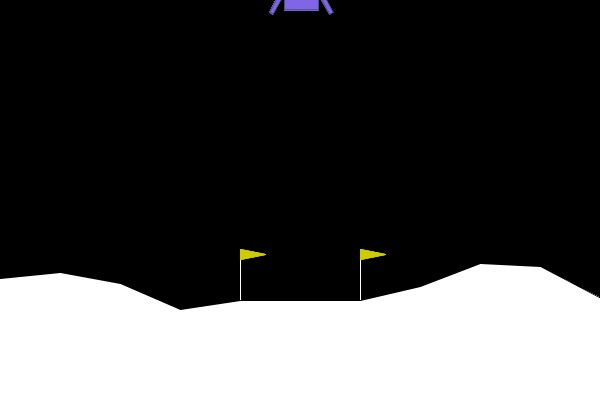

In [9]:
env.reset()
PIL.Image.fromarray(env.render(mode='rgb_array'))

In [10]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: (8,)
Number of actions: 4


In [11]:
# Reset the environment and get the initial state.
initial_state = env.reset()

In [12]:
# Select an action
action = 0

# Run a single time step of the environment's dynamics with the given action.
next_state, reward, done, info = env.step(action)

with np.printoptions(formatter={'float': '{:.3f}'.format}):
    print("Initial State:", initial_state)
    print("Action:", action)
    print("Next State:", next_state)
    print("Reward Received:", reward)
    print("Episode Terminated:", done)
    print("Info:", info)

Initial State: [0.006 1.406 0.565 -0.203 -0.006 -0.128 0.000 0.000]
Action: 0
Next State: [0.011 1.401 0.564 -0.229 -0.013 -0.126 0.000 0.000]
Reward Received: -0.9662702608946745
Episode Terminated: False
Info: {}


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [15]:
# Create the Q-Network
q_network = Sequential([
    ### START CODE HERE ###
    Input(shape=state_size),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_actions, activation='linear'),
    ### END CODE HERE ###
    ])

# Create the target Q^-Network
target_q_network = Sequential([
    ### START CODE HERE ###
    Input(shape=state_size),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_actions, activation='linear'),
    ### END CODE HERE ###
    ])

### START CODE HERE ###
optimizer = Adam(learning_rate=ALPHA)
### END CODE HERE ###

In [18]:
# UNIT TEST
from public_tests import *

# test_network(q_network)
# test_network(target_q_network)
# test_optimizer(optimizer, ALPHA)

ValueError: The layer sequential_2 has never been called and thus has no defined input.

In [19]:
# Store experiences as named tuples
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [20]:
def compute_loss(experiences, gamma, q_network, target_q_network):
    """
    Calculates the loss.

    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
      q_network: (tf.keras.Sequential) Keras model for predicting the q_values
      target_q_network: (tf.keras.Sequential) Karas model for predicting the targets

    Returns:
      loss: (TensorFlow Tensor(shape=(0,), dtype=int32)) the Mean-Squared Error between
            the y targets and the Q(s,a) values.
    """

    # Unpack the mini-batch of experience tuples
    states, actions, rewards, next_states, done_vals = experiences

    # Compute max Q^(s,a)
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)

    # Set y = R if episode terminates, otherwise set y = R + γ max Q^(s,a).
    ### START CODE HERE ###
    y_targets = rewards + (gamma * max_qsa * (1 - done_vals))
    ### END CODE HERE ###

    # Get the q_values
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))

    # Compute the loss
    ### START CODE HERE ###
    loss = MSE(y_targets, q_values)
    ### END CODE HERE ###

    return loss

In [21]:
# UNIT TEST
test_compute_loss(compute_loss)

All tests passed!


In [22]:
@tf.function
def agent_learn(experiences, gamma):
    """
    Updates the weights of the Q networks.

    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.

    """

    # Calculate the loss
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # Get the gradients of the loss with respect to the weights.
    gradients = tape.gradient(loss, q_network.trainable_variables)

    # Update the weights of the q_network.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    # update the weights of target q_network
    utils.update_target_network(q_network, target_q_network)

In [23]:
start = time.time()

num_episodes = 2000
max_num_timesteps = 1000

total_point_history = []

num_p_av = 100    # number of total points to use for averaging
epsilon = 1.0     # initial ε value for ε-greedy policy

# Create a memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE)

# Set the target network weights equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):

    # Reset the environment to the initial state and get the initial state
    state = env.reset()
    total_points = 0

    for t in range(max_num_timesteps):

        # From the current state S choose an action A using an ε-greedy policy
        state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network
        q_values = q_network(state_qn)
        action = utils.get_action(q_values, epsilon)

        # Take action A and receive reward R and the next state S'
        next_state, reward, done, _ = env.step(action)

        # Store experience tuple (S,A,R,S') in the memory buffer.
        # We store the done variable as well for convenience.
        memory_buffer.append(experience(state, action, reward, next_state, done))

        # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
        update = utils.check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)

        if update:
            # Sample random mini-batch of experience tuples (S,A,R,S') from D
            experiences = utils.get_experiences(memory_buffer)

            # Set the y targets, perform a gradient descent step,
            # and update the network weights.
            agent_learn(experiences, GAMMA)

        state = next_state.copy()
        total_points += reward

        if done:
            break

    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])

    # Update the ε value
    epsilon = utils.get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    # We will consider that the environment is solved if we get an
    # average of 200 points in the last 100 episodes.
    if av_latest_points >= 200.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('lunar_lander_model.h5')
        break

tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 100 | Total point average of the last 100 episodes: -150.17
Episode 200 | Total point average of the last 100 episodes: -108.89
Episode 300 | Total point average of the last 100 episodes: -38.60
Episode 400 | Total point average of the last 100 episodes: 118.37
Episode 500 | Total point average of the last 100 episodes: 188.37
Episode 524 | Total point average of the last 100 episodes: 199.85

Episode 525 | Total point average of the last 100 episodes: 202.53

Environment solved in 525 episodes!

Total Runtime: 1511.23 s (25.19 min)


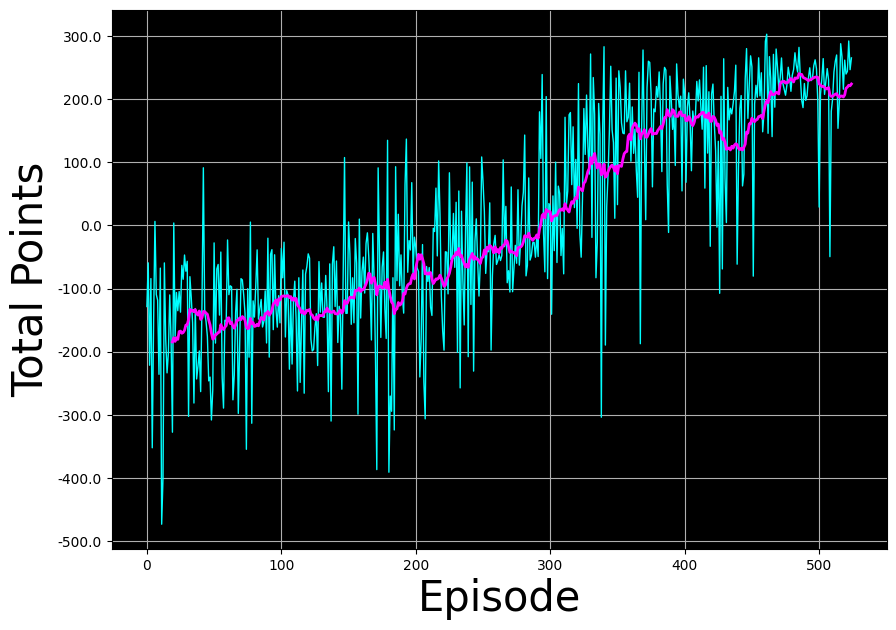

In [24]:
# Plot the point history
utils.plot_history(total_point_history)

In [25]:
# Suppress warnings from imageio
import logging
logging.getLogger().setLevel(logging.ERROR)

In [27]:
filename = "/content/lunar_lander.mp4"

utils.create_video(filename, env, q_network)
utils.embed_mp4(filename)

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
